# Music Generator


This project makes use of autoencoders (LSTMs) to learn and predict musical sequences. 

Music is traditionally represented as a sequence of notes, rests, and their duration. In a single bar of a 4/4 time signature, we may have a whole note, half note, quarter note, eight note and so on, with some combination of complex notes and rests. For example: we may have a note of duration 3/8s which is a quarter note extended with another eight note.

One may therefore choose to learn and predict notes with their durations, in the same represenation musical sheets represent them. We however, chose to represent notes as a sequence of vectors [inspired by this paper](https://mail.google.com/mail/u/1/#search/blues/KtbxLthKLdMJhtGbjfznrHwWJMVxscXTLV). A bar is divided into 32 vectors representing 16 notes on beat and 16 notes off-beat. Each vector is 72 binary elements long, representing all notes on a 24 fret guitar flow the lowest pitch to the highest pitch. In this representation, a quarter note on beat consists of 4 identical vectors. The amountof notes per bar (32 in our case) is the resolution we allow in the music. The downside of this approach is that two consecutive sixteenth notes are identical to a single eigth note. It can be solved with a higher resolution with the compromise of a larger data representation.

By representing notes in such a way, we could formulate the problem as 72 items prediction problem, where we wish to predict the chance of any note to be played at a given time tick. However, since we wished for simplicity, we decided to formulate the problem as a finite category sequence generation problem, akin to text generation. We chose the highest frequence ~630 note configuration (note the total category set may contain up to 2^72 configurations), and filtered the data to only sequences with the chosen categories. Now at each point in time, we can choose 1 out of 636 options to play based on the previous 100 timeticks. The approach was inspired from [this artical](https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/)

### Midi files
The original data was taken from files in the MIDI format. Reductively - midi format is a digital representation of events taking place on a musical instrument. Event may be a pedal press, note on, note off, program (musical instrument) change, etc. We did not include the **preprocessing** phase documentation here, although the code is available in the preprocessing.py file. We made that decision because it is a code-heavy operation and we wanted to focus on the theoretical machine learning formulation.


In [39]:
from keras.models import Sequential
import keras
from keras.utils import np_utils
import preprocessing
import postprocessing
import os
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
import pickle


## Load the the preprocessed data
As mentioned, the data containes 636 note configurations, which we will refer to as "categories". The input data consists of batches of 100 timeticks, each should be followed by a known note vector in the appropriate output data index.

In [46]:
#load the data from saved files
sequence_length = 100
pwd = os.path.dirname(os.path.realpath('__file__'))
input_src = os.path.join(pwd, "saved_data","processed_200_filtered_net_input_final.txt")
output_src = os.path.join(pwd, "saved_data","processed_200_filtered_net_output_final.txt")
vocab_src = os.path.join(pwd, "saved_data","processed_200_filtered_vocabularies_final.pkl")

network_input = np.loadtxt(input_src, dtype=int)
network_output = np.loadtxt(output_src, dtype=int)
with open(vocab_src,'rb') as f: 
    str_to_int, int_to_str, count_int = pickle.load(f) #configuration to category conversions and counts 

print("input data shape: {0}".format(network_input.shape))
print("output data shape: {0}".format(network_output.shape))

input data shape: (27115, 100)
output data shape: (27115,)


We have 27115 different sequences we can learn from. Note (pun intended) that up to 200 consecutive sequence may be from the same musical track (see "filtering" notebook for further details)

## Examine the data
Here we can get an idea of the frequecy of each category. Let's see the most frequent 10 categories. We expect the zero vector (representing a rest) to be the most frequent, but we hope to see a relatively uniform distribution of categores except that

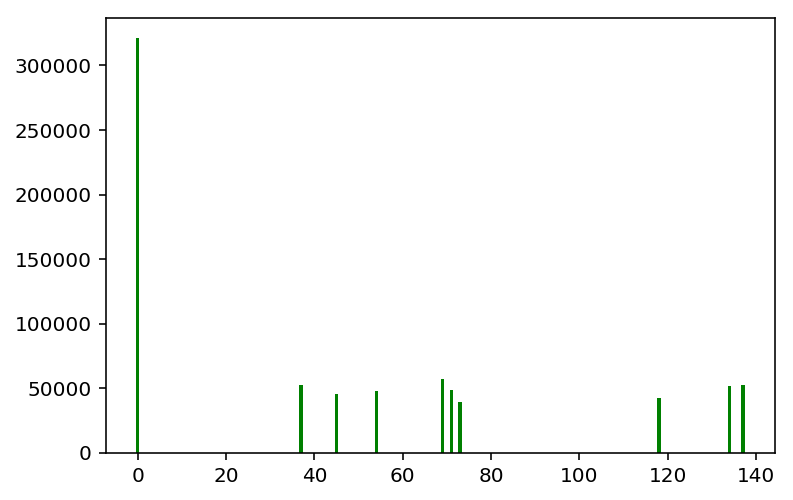

In [48]:
import matplotlib.pyplot as plt
dict_keys = [k for k,v in sorted([(k,v) for k,v in count_int.items()], key=lambda tup: tup[1])[::-1]]
dict_vals = sorted([v for k,v in count_int.items()])[::-1]
#show the 10 most common note configurations
plt.bar(dict_keys[:10], dict_vals[:10], color='g')
plt.show()

### Preparing the data for the model
Since many sequences are taken from the same track consecutively, we should shuffle them before feeding them to the model. We also want to perform cross validation, so we'll split the data into train and test samples 

In [50]:
# Shuffle data
n = network_input.shape[0]
I = np.random.permutation(n)

#define test and test sizes
ntr = 20000
nts = 5000

X = network_input[I[:ntr+nts]]
y = network_output[I[:ntr+nts]]

nclass = np.maximum(np.max(X), np.max(y)) #amount of different configurations in the data

#one-hot code
X = np_utils.to_categorical(X, num_classes=nclass+1) 
y = np_utils.to_categorical(y, num_classes=nclass+1)

#split to train and test
Xtr = X[:ntr]
ytr = y[:ntr]
Xts = X[ntr:ntr+nts]
yts = y[ntr:ntr+nts]

## train / load model

In [51]:
import keras.backend as K
K.clear_session()

In [52]:
final_model = Sequential()
final_model.add(keras.layers.LSTM(
        3,
        input_shape=(Xtr.shape[1], Xtr.shape[2]),
        return_sequences=True
    ))
final_model.add(keras.layers.Dropout(0.3))
final_model.add(keras.layers.LSTM(128,return_sequences=True)) #sub with catego
final_model.add(keras.layers.Dropout(0.3))
final_model.add(keras.layers.LSTM(128))
final_model.add(keras.layers.Dropout(0.3))
final_model.add(keras.layers.Dense(ytr.shape[1]))
final_model.add(keras.layers.Activation('softmax'))



pwd = os.path.dirname(os.path.realpath('__file__'))
filepath = os.path.join(pwd, "models", "weights-improvement-{epoch:02d}-{loss:.4f}-waitingModel-alldata.hdf5")   
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=1,        
    save_best_only=True,        
    mode='min')

callbacks_list = [checkpoint]     


# load the network weights

filename = "weights-improvement-160-1.1110-alldata_final.hdf5"
model_path = os.path.join(pwd, "models", filename)
final_model.load_weights(model_path) #use this line to load the weights of the pretrained model

final_model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
#hist = final_model.fit(Xtr, ytr, epochs=400, batch_size=256, callbacks=callbacks_list, validation_data=(Xts,yts)) #use this line to train a new model

final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100, 3)            7680      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 3)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 128)          67584     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 636)               82044     
__________

Here we loaded a model that we trained over night and reached a ~1.1 loss value. The model is slightly overfitted, but we find it to sound better on a test seed than all other models. The model has 288,892 parameters which although exceed the amount of examples we had, produce a decent sequece (as we will see soon)

### Showtime
Now that our model is ready we can give it a seed sequence to start predicting. We will use a random sequence from the test samples and use the postprocessing.py package that we wrote in order to convert it back to a midi file and save it. Upon execution of this cell, an "original.mid" file (representing the original test sequence) and a "prediction.mid" file will be saved to the working folder. You should be able to play them with GarageBand on a mac or Media Player on windows.

In [53]:
import random
ind = random.randint(0,Xts.shape[0])
print("Testing test pattern at {0}".format(ind))
nt = 500 #amount of notes to predict
ynew = np.zeros(nt)
pat_len = X.shape[1]
pat = np.reshape(Xts[ind], (1,Xts.shape[1],Xts.shape[2]))
patC = np.copy(pat)
res = np.copy(pat)
print(res.shape)
for t in range(nt):
    prob = final_model.predict(pat)
    pred = np.argmax(prob)
    print(pred,end=",")
    newNote = np.zeros((1,1,X.shape[2]))
    newNote[0,0,pred] = 1.0
    pat = np.append(pat,newNote,axis=1)
    res = np.append(res,newNote,axis=1)
    pat = pat[:,1:sequence_length+1,:]

print()
print(res[0].shape)
noteMat = np.zeros((res[0].shape[0],72),dtype=int)
for veci, vec in enumerate(res[0]):
    nextNoteInt = 0
    for i,e in enumerate(vec):
        if e > 0:
            nextNoteInt = int(i)
            break
    noteMat[veci] = np.array([int(b) for b in int_to_str[nextNoteInt]])
noteMat[-1] = np.zeros(72,dtype=int)
postprocessing.convertMatToTrack(noteMat.T,32,"prediction.mid")


noteMat = np.zeros((100,72),dtype=int)
for veci, vec in enumerate(patC[0]):
    nextNoteInt = 0
    for i,e in enumerate(vec):
        if e > 0:
            nextNoteInt = int(i)
            break
    noteMat[veci] = np.array([int(b) for b in int_to_str[nextNoteInt]])
noteMat[-1] = np.zeros(72,dtype=int)
postprocessing.convertMatToTrack(noteMat.T,32,"original.mid")

Testing test pattern at 3962
(1, 100, 636)
149,544,544,149,149,208,208,208,208,539,539,539,538,490,490,540,540,540,540,540,540,541,541,542,539,539,539,543,543,544,544,149,149,544,544,149,149,208,208,208,208,539,539,539,538,490,490,540,540,540,540,540,540,541,541,542,539,539,539,543,543,544,544,149,149,544,544,149,149,208,208,208,208,539,539,539,538,490,490,540,540,540,540,540,540,541,541,542,539,539,539,543,543,544,544,149,149,544,544,149,149,208,208,208,208,539,539,538,538,490,490,540,540,540,540,540,540,541,541,542,539,539,543,543,544,544,544,149,149,544,544,149,149,208,208,208,208,539,539,538,538,490,490,540,540,540,540,540,540,541,541,542,539,539,543,543,544,544,544,149,149,544,544,149,149,208,208,208,208,539,539,538,538,490,490,540,540,540,540,540,540,541,541,542,539,539,543,543,544,544,544,149,149,544,544,149,149,208,208,208,208,539,539,539,538,490,490,540,540,540,540,540,540,541,541,542,539,539,543,543,544,544,149,149,544,544,544,149,149,208,208,208,208,539,539,539,538,490,490,5

### Conclusion and further work

We made a few compromises in this project, the two largest of them is using "Smushed" midi tracks containing multiple tracks merged together, and predicting categories instead of probabilities of notes being on/off. Both issued limited the expanse of results we could have achieved, but it made executing the solution a bit easier.

For further work we may want to train more, on a larger network. Midi files are plenty and available, but time was not so. Given more time and higher processing power (which we can get using a GPU) we can try out better architectures. We could also restrict the genre of the data so that our generation will be less "all over the place".

Overall, we're happy with the result. Even though there is no metric by which we can validate the quality of the procuced tracks, we think they sound decent. Or as was said before "it won't win a Grammy, but it's pretty good".